In [11]:
from models_new.nac import NAC
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook as tqdm

from data_generator_helper import generate_synthetic_selection_dataset_with_function

from models_new.nac import NeuralAccumulatorCell
import torch
import torchvision.utils as vutils
import numpy as np
import torchvision.models as models
from torchvision import datasets
from tensorboardX import SummaryWriter
import datetime
import os

In [58]:
def reportLoss(loss, epoch):
    print("epoch {},  \t loss {}".format(epoch, loss))
    
def train(model, optimizer, x_train, y_train, epochs, batch_size):
    t_loss = []
    g_model = []
    for epoch in range(epochs):
        
        #print('G is: ',model.G.data)
        #print('g is: ',torch.sigmoid(model.G))
        
        for batch in range(len(x_train) // batch_size):
            
            model.train()
            optimizer.zero_grad()

            x_batch_train = x_train[batch:(batch+batch_size),:]
            y_batch_train = y_train[batch:(batch+batch_size)].unsqueeze(1)


            out = model(x_batch_train)

            loss = F.mse_loss(out, y_batch_train)
            
            if loss != loss:
                break
                print("nan detected")
            
            loss.backward()
            optimizer.step()
        #print(model.g[0])
        if loss != loss:
            break
        
        if epoch % 100 == 0: 
            #pass
            reportLoss(loss.data, epoch)
        if epoch % 2 == 0:
            t_loss.append(loss.data)
            g_model.append(np.asscalar(model.g[0].detach().numpy()))
        
        #model.temperature = epoch * 0.001
            
    return test(model,x_train,y_train), t_loss,g_model
        
def test(model, x_test, y_test):
    
    model.eval()
    output_test = model(x_test)
    #print(output_test)
    loss = F.mse_loss(output_test.squeeze(), y_test)
    #print("Test loss: ", loss)
    return loss

In [59]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn.parameter import Parameter


class NeuralAccumulatorCell(nn.Module):
    """A Neural Accumulator (NAC) cell [1].
    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.
    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim, ini):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.initial = ini
        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))

        self.register_parameter('W_hat', self.W_hat)
        self.register_parameter('M_hat', self.M_hat)
        self.register_parameter('bias', None)

        self._reset_params(ini)

    def _reset_params(self,ini):
        if ini =='Kai_uni':
            init.kaiming_uniform_(self.W_hat)
            init.kaiming_uniform_(self.M_hat)

        if ini =='Xav_norm':
            init.xavier_normal_(self.W_hat)
            init.xavier_normal_(self.M_hat)

        if ini =='Kai_norm':
            init.kaiming_normal_(self.W_hat)
            init.kaiming_normal_(self.M_hat)

        if ini =='Zeros':
            init.zeros_(self.W_hat)
            init.zeros_(self.M_hat)

        if ini =='Ones':
            init.ones_(self.W_hat)
            init.ones_(self.M_hat)

    def forward(self, input):
        W = torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat)
        return F.linear(input, W, self.bias)

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )

In [60]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn.parameter import Parameter
import numpy as np

class NeuralArithmeticLogicUnitCell(nn.Module):
    """A Neural Arithmetic Logic Unit (NALU) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim, ini):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(1, 2))
        #print(self.G)
        self.nac = NeuralAccumulatorCell(in_dim, out_dim, ini)
        self.register_parameter('bias', None)
        self.temperature = 0.005
        
        if ini =='Kai_uni':
            init.kaiming_uniform_(self.G, a=math.sqrt(5))

        if ini =='Xav_norm':
            init.xavier_normal_(self.G)

        if ini =='Kai_norm':
            init.kaiming_normal_(self.G)

        if ini =='Zeros':
            init.zeros_(self.G)

        if ini =='Ones':
            init.ones_(self.G)


    def forward(self, input):
        a = self.nac(input)

        self.g = torch.sigmoid(F.linear(input, self.G, self.bias))
        #g = torch.sigmoid(self.G)
        #print(g)
        
        add_sub = self.g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        mul_div = (1 - self.g) * m
        y = add_sub + mul_div
        return y
    
    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


In [113]:
test_per_range = 4
sample_size = 2
set_size = 100

in_dim = sample_size
hidden_dim = 1
out_dim = 1
num_layers = 1

lr = 0.01
epochs = 1000
batch_size = 1

#values = np.linspace(1,1000,10)
#inits = ['Kai_norm']
train_values = [[0,1],[-1,1]]
test_values = [[0,10],[0,100],[-10,10],[-100,100]]

train_loss = np.zeros((len(test_values),2))
test_loss = np.zeros((len(test_values),2))

loss_list = {}
g_list = {}
counter = 0
for k, t_val in enumerate(train_values):
    print("Training range: ", t_val)

    for j, val in tqdm(enumerate(test_values)):

        print("Testing range: ",val)
        exp_loss_train = []
        exp_loss_test = []
        loss_list_temp = []
        g_list_temp = []
        for i in range(test_per_range):
            
            model = NeuralArithmeticLogicUnitCell(in_dim, out_dim, 'Kai_uni')
            optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)

            x_train, y_train, boundaries = generate_synthetic_selection_dataset_with_function(t_val[0], t_val[1],
                                                                        sample_size, set_size, function = 'add', boundaries = None)

            x_test, y_test, _ = generate_synthetic_selection_dataset_with_function(val[0], val[1],
                                                                        sample_size, set_size, function = 'add', boundaries = boundaries)
            
            temp1,loss_temp,g_out = train(model, optimizer, x_train, y_train, epochs, batch_size)
            temp2  = test(model, x_test, y_test)
            exp_loss_train.append(temp1)
            exp_loss_test.append(temp2)
              
            g_list_temp.append(g_out)
            loss_list_temp.append(loss_temp)
            
        minarg = np.argmin(exp_loss_train)
        loss_list[counter] = loss_list_temp[minarg]
        g_list[counter] = g_list_temp[minarg]
        train_loss[j, k] = np.min(exp_loss_train)
        test_loss[j, k] = np.min(exp_loss_test)
        counter += 1

Training range:  [0, 1]


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Testing range:  [0, 10]
epoch 0,  	 loss 0.010203976184129715
epoch 100,  	 loss 0.0074558015912771225
epoch 200,  	 loss 0.007926727645099163
epoch 300,  	 loss 0.007805163972079754
epoch 400,  	 loss 0.007633762899786234
epoch 500,  	 loss 0.0074970112182199955
epoch 600,  	 loss 0.00741531141102314
epoch 700,  	 loss 0.007376886438578367
epoch 800,  	 loss 0.00736137293279171
epoch 900,  	 loss 0.007355666719377041
epoch 0,  	 loss 0.0847087949514389
epoch 100,  	 loss 0.025318708270788193
epoch 200,  	 loss 0.02473605051636696
epoch 300,  	 loss 0.024499334394931793
epoch 400,  	 loss 0.024400988593697548
epoch 500,  	 loss 0.024365024641156197
epoch 600,  	 loss 0.02435293234884739
epoch 700,  	 loss 0.024348987266421318
epoch 800,  	 loss 0.024347834289073944
epoch 900,  	 loss 0.024347424507141113
epoch 0,  	 loss 0.1808200627565384
epoch 100,  	 loss 0.04040362685918808
epoch 200,  	 loss 0.013767353259027004
epoch 300,  	 loss 0.0027527722995728254
epoch 400,  	 loss 1.9114389

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Testing range:  [0, 10]
epoch 0,  	 loss 0.04269260913133621
epoch 100,  	 loss 0.12362638860940933
epoch 200,  	 loss 0.13099628686904907
epoch 300,  	 loss 0.13074086606502533
epoch 400,  	 loss 0.12889264523983002
epoch 500,  	 loss 0.1272667646408081
epoch 600,  	 loss 0.12652671337127686
epoch 700,  	 loss 0.12651680409908295
epoch 800,  	 loss 0.1268291473388672
epoch 900,  	 loss 0.127205029129982
epoch 0,  	 loss 0.643425703048706
epoch 100,  	 loss 0.0414443276822567
epoch 200,  	 loss 0.04038538038730621
epoch 300,  	 loss 0.039758604019880295
epoch 400,  	 loss 0.039461277425289154
epoch 500,  	 loss 0.03934796527028084
epoch 600,  	 loss 0.03930989280343056
epoch 700,  	 loss 0.03929777815937996
epoch 800,  	 loss 0.03929416462779045
epoch 900,  	 loss 0.039293039590120316
epoch 0,  	 loss 0.2566434144973755
epoch 100,  	 loss 0.04227820783853531
epoch 200,  	 loss 0.0403125137090683
epoch 300,  	 loss 0.03974294289946556
epoch 400,  	 loss 0.039584752172231674
epoch 500,  

In [114]:
train_loss

array([[0.10227281, 0.2008756 ],
       [0.10528643, 0.24959697],
       [0.10597976, 0.24307448],
       [0.09475661, 0.23803368]])

In [115]:
test_loss

array([[   79.91027069,    44.15198135],
       [10577.6796875 ,  7434.89599609],
       [   92.472229  ,    38.03020477],
       [ 8830.14453125,  5187.31689453]])

In [103]:
len(loss_list)

8

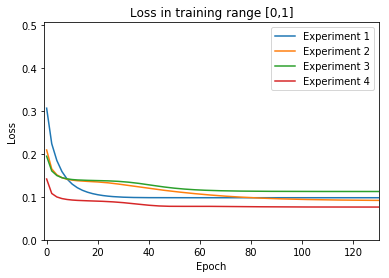

In [112]:
mmax = 0
for i in range(4):
    plt.plot(np.arange(0, 1000, 2), loss_list[i])
    if mmax <  max(loss_list[i]):
        mmax =  max(loss_list[i])
    
plt.legend(["Experiment 1","Experiment 2","Experiment 3","Experiment 4"])
plt.title("Loss in training range [0,1]")
plt.ylim([0,mmax+0.2])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([-1,130])
plt.show()

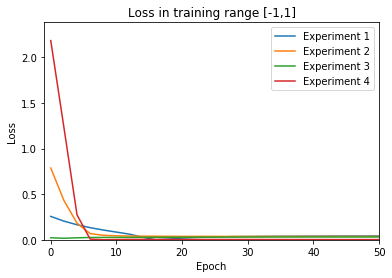

In [121]:
mmax = 0
for i in range(4):
    plt.plot(np.arange(0, 1000, 2), loss_list[4+i])
    if mmax <  max(loss_list[4+i]):
        mmax =  max(loss_list[4+i])
    
plt.legend(["Experiment 1","Experiment 2","Experiment 3","Experiment 4"])
plt.title("Loss in training range [-1,1]")
plt.ylim([0,mmax+0.2])
plt.xlim([-1,50])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

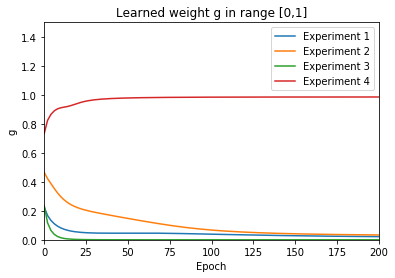

In [117]:
for i in range(4):
    plt.plot(np.arange(0, 1000, 2), g_list[i])

plt.legend(["Experiment 1","Experiment 2","Experiment 3","Experiment 4"])
plt.title("Learned weight g in range [0,1]")
plt.ylim([0,1.5])
plt.xlim([0,200])
plt.ylabel('g')
plt.xlabel('Epoch')
plt.show()

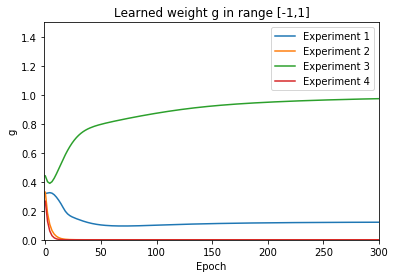

In [124]:
for i in range(4):
    plt.plot(np.arange(0, 1000, 2), g_list[4+i])

plt.legend(["Experiment 1","Experiment 2","Experiment 3","Experiment 4"])
plt.title("Learned weight g in range [-1,1]")
plt.ylim([0,1.5])
plt.xlim([-1,300])
plt.ylabel('g')
plt.xlabel('Epoch')
plt.show()

In [94]:
exp_loss_train

[tensor(0.2992, grad_fn=<MseLossBackward>)]